In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
import pickle





In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:


class TextProcessor:
    def __init__(self, data_file: str, freq_threshold: int = 5):
        """
        Initializes a TextProcessor object.

        Args:
            data_file (str): The path to the CSV file containing the text data.
            freq_threshold (int, optional): The frequency threshold for word occurrence. Defaults to 5.
        """
        self.data_file = data_file
        self.dataset = pd.read_csv(data_file)
        self.freq_threshold = freq_threshold

    def process_text(self) -> tuple:
        """
        Processes the text data.

        Returns:
            tuple: A tuple containing:
                - token_mappings (list of lists): Token mappings for each sentence in the dataset.
                - reverse_word_mapper (dict): Mapping from index to word.
        """
        spacy.prefer_gpu()

        text_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
        tokenized_text = []
        sentence_groups = []
        for entry in self.dataset['text'].tolist():
            tokenized_text.append(text_tokenizer(entry))
            sentence_groups.append(entry.split('.'))

        self.dataset['grouped_sentences'] = sentence_groups

        word_counter = Counter()
        for line in tokenized_text:
            for word in line:
                word_counter[word] += 1

        word_mapper = {word[0]: idx+1 for idx, word in enumerate(word_counter.most_common())}
        reverse_word_mapper = {idx+1: word[0] for idx, word in enumerate(word_counter.most_common())}
        other_index = len(word_counter.keys())

        token_mappings = []
        for line in tokenized_text:
            mapped_line = []
            for word in line:
                mapped_line.append(word_mapper.get(word, other_index))
            token_mappings.append(mapped_line)

        return token_mappings, reverse_word_mapper





In [ ]:
def compute_paragraph_similarity(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the similarity scores between consecutive sentences within each paragraph.

    Args:
        dataset (pd.DataFrame): The dataset containing text data.

    Returns:
        pd.DataFrame: The dataset with similarity scores added as a new column.
    """
    similarity_scores = []
    for paragraph in dataset['grouped_sentences'].tolist():
        similarity = 200
        initial_sentence = paragraph[0]
        paragraph = paragraph[1:]
        for sentence in paragraph:
            tokenized_initial = word_tokenize(initial_sentence)
            tokenized_current = word_tokenize(sentence)

            sw = set(stopwords.words('english'))
            initial_set = {w for w in tokenized_initial if not w in sw}
            current_set = {w for w in tokenized_current if not w in sw}

            combined_set = initial_set.union(current_set)
            vector1 = [1 if w in initial_set else 0 for w in combined_set]
            vector2 = [1 if w in current_set else 0 for w in combined_set]

            dot_product = sum(i * j for i, j in zip(vector1, vector2))
            try:
                cosine_similarity = dot_product / float((sum(vector1)*sum(vector2))**0.5)
                if similarity > cosine_similarity:
                    similarity = cosine_similarity
            except ZeroDivisionError:
                similarity += 0

            initial_sentence = sentence

        similarity_scores.append(similarity)

    dataset['similarity_scores'] = similarity_scores

    return dataset

The GCDC Corpus comprises four datasets, each comprising 1000 training entries and 200 test entries. To compensate for limited data availability, we utilize all four training sets and two of the test sets for training, reserving one test set for evaluating results. [link text](https://github.com/aylai/GCDC-corpus)
```markdown

GCDC_rerelease/
|--- Clinton_test.csv      # Test set for Clinton data (200 entries)
|--- Clinton_train.csv     # Training set for Clinton data (1000 entries)
|--- Enron_test.csv        # Test set for Enron data (200 entries)
|--- Enron_train.csv       # Training set for Enron data (1000 entries)
|--- Yahoo_test.csv        # Test set for Yahoo data (200 entries)
|--- Yahoo_train.csv       # Training set for Yahoo data (1000 entries)
|--- Yelp_test.csv         # Test set for Yelp data (200 entries)
|--- Yelp_train.csv        # Training set for Yelp data (1000 entries)
```



In [ ]:
base_path = '/content/gdrive/MyDrive/Inlp-Project/Datasets/GCDC_rerelease/'

# Training data
data1 = pd.read_csv(base_path + 'Clinton_train.csv')
data2 = pd.read_csv(base_path + 'Yahoo_train.csv')
data3 = pd.read_csv(base_path + 'Yelp_train.csv')
data4 = pd.read_csv(base_path + 'Enron_train.csv')

# Test data
data5 = pd.read_csv(base_path + 'Clinton_test.csv')
data6 = pd.read_csv(base_path + 'Yahoo_test.csv')
data7 = pd.read_csv(base_path + 'Enron_test.csv')
data8 = pd.read_csv(base_path + 'Yelp_test.csv')


In [ ]:
data1 = pd.concat([data1, data2, data3, data4, data5, data6])
data2 = pd.concat([data7,data8])


In [ ]:
data1.to_csv(base_path+'/combined_train.csv')
data2.to_csv(base_path+'/combined_test.csv')

` Loading Combined Train and Test Data`




In [ ]:
train = TextProcessor(base_path+"combined_train.csv")
test = TextProcessor(base_path+"combined_test.csv")


In [ ]:
train_size = len(train.dataset)
test_size = len(test.dataset)

# Print the sizes
print("Size of train dataset:", train_size)
print("Size of test dataset:", test_size)

Size of train dataset: 4400
Size of test dataset: 400


LabelA in the GCDC dataset signifies the coherence level of text entries, ranging from '1' for low coherence to '3' for high coherence, based on consensus ratings from three expert evaluators.

In [ ]:
train_labels = np.array(train.dataset['labelA'])
train_encoded_labels = to_categorical(train_labels)
print("Original Labels:")
print(train_labels)
print("\nOne-Hot Encoded Labels:")
print(train_encoded_labels)

Original Labels:
[2 2 3 ... 3 1 3]

One-Hot Encoded Labels:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [ ]:
test_labels = np.array(test.dataset['labelA'])
test_encoded_labels = to_categorical(test_labels)

print("Original Labels for Test Dataset:")
print(test_labels)
print("\nOne-Hot Encoded Labels for Test Dataset:")
print(test_encoded_labels)

Original Labels for Test Dataset:
[3 1 3 1 3 1 2 2 3 3 3 2 3 2 1 1 1 1 1 3 3 3 3 3 2 2 1 1 3 3 2 3 3 3 1 3 3
 2 2 2 2 3 3 2 3 3 2 1 2 3 3 3 2 2 1 1 3 3 1 1 2 2 2 1 3 3 1 1 1 3 1 2 3 1
 3 1 3 3 1 1 2 3 1 2 1 3 3 1 2 2 3 3 3 1 1 2 3 3 3 3 3 1 3 2 1 3 1 3 2 3 2
 1 1 2 3 3 3 3 1 3 3 3 3 1 1 2 3 2 2 2 2 3 3 1 3 2 2 2 3 1 2 3 2 2 1 2 3 3
 1 3 1 3 2 1 2 3 1 3 3 1 1 3 3 1 2 1 3 3 2 1 2 1 1 1 1 1 1 1 3 2 1 3 3 3 3
 2 3 3 1 3 3 1 2 3 3 3 1 3 2 1 1 1 1 3 3 3 2 3 1 1 2 3 1 3 2 3 3 1 3 3 3 3
 3 1 3 3 1 3 1 2 3 3 3 3 3 3 1 3 3 3 3 2 3 2 3 3 2 2 1 1 3 1 3 2 3 3 3 2 2
 3 1 2 3 1 2 2 3 3 2 3 2 2 1 3 3 2 3 3 2 3 3 2 2 1 3 1 3 2 3 2 3 2 1 3 1 3
 1 1 3 3 1 3 1 3 3 1 3 3 3 1 3 1 3 1 1 3 2 3 2 3 3 3 3 3 2 2 2 3 2 3 3 3 3
 3 1 3 3 1 3 3 3 1 3 3 3 1 2 3 3 1 1 1 3 2 2 2 1 1 1 3 3 3 1 1 1 3 3 2 1 3
 1 3 2 2 3 3 3 2 2 3 3 3 3 3 3 1 1 1 3 1 3 3 2 1 3 3 2 3 3 2]

One-Hot Encoded Labels for Test Dataset:
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
train_mapped_tokens, train_inverse_mapper = train.process_text()
test_mapped_tokens, test_inverse_mapper = test.process_text()


In [ ]:
print("Processed Data for Training Dataset:")
print(train_mapped_tokens[:1])
print("Inverse Mapper for Training Dataset:")
print(train_inverse_mapper)

print("\nProcessed Data for Testing Dataset:")
print(test_mapped_tokens[:1])
print("Inverse Mapper for Testing Dataset:")
print(test_inverse_mapper)


Processed Data for Training Dataset:
[[445, 96, 15, 1510, 23, 10, 6, 76, 106, 4, 867, 4807, 4, 458, 6570, 2870, 64, 101, 17, 18814, 10, 854, 70, 15, 91, 47, 3, 7, 40, 397, 23, 265, 80, 4, 462, 17, 854, 2223, 5, 7, 28, 57, 2, 11092, 371, 4, 327, 2, 4807, 1, 227, 28, 21, 2581, 4, 88, 14, 2507, 242, 3, 79, 28, 4044, 80, 4, 911, 2058, 14, 3483, 3, 1908, 1121, 18815, 3, 293, 1, 3, 5, 24, 2507, 141, 837, 28, 1792, 80, 183, 2, 231, 8, 2, 512, 17, 912, 478, 3, 3835, 1, 118, 513, 40, 176, 49, 376, 242, 44, 47, 8, 5530, 145, 6, 5991, 2280, 14, 7289, 17, 976, 1541, 1, 15, 7, 100, 26, 2871, 17, 9402, 58, 4, 7289, 173, 2, 1909, 23, 57, 2, 73, 51, 12, 4, 21, 249, 3, 5, 23, 129, 26, 57, 1793, 33, 1910, 58, 33, 145, 23, 3206, 34, 26, 6, 18816, 18817, 1766, 3, 199, 23, 50, 373, 2118, 11, 2966, 14, 1015, 44, 912, 32, 1, 179, 3, 45, 2, 2681, 22, 10, 106, 3, 4507, 5, 7, 40, 68, 4, 87, 58, 1323, 27, 976, 10, 211, 4, 2014, 10, 11093, 678, 17, 976, 2508, 27, 494, 1, 15, 189, 9403, 27, 10, 2967, 12, 1054, 14,

The `compute_paragraph_similarity` function computes the similarity scores between consecutive sentences within each paragraph of the input dataset and adds these scores as a new column in the dataset.

1. Iterate through each paragraph in the dataset, tokenize each sentence, and compute the cosine similarity between consecutive sentences.
2. Add the computed similarity scores as a new column named 'similarity_scores' to the input dataset and return the modified dataset.




In [ ]:
train.dataset = compute_paragraph_similarity(train.dataset)
test.dataset = compute_paragraph_similarity(test.dataset)

In [ ]:
train.dataset['encoding'] = train_mapped_tokens
test.dataset['encoding'] = test_mapped_tokens

In [ ]:
train.dataset['labelA']

0       2
1       2
2       3
3       1
4       1
       ..
4395    1
4396    1
4397    3
4398    1
4399    3
Name: labelA, Length: 4400, dtype: int64

#LSTM model split into training and testing sets (4600/400) for Yelp and Enron data, functioning as a multi-classifier.

In [ ]:
from tensorflow.keras.preprocessing import sequence

np.random.seed(7)
X_training = sequence.pad_sequences(train.dataset['encoding'], maxlen=500)
y_training = train_encoded_labels
X_testing = sequence.pad_sequences(test.dataset['encoding'], maxlen=500)
y_testing = test_encoded_labels


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           2560000   
                                                                 
 lstm (LSTM)                 (None, 500, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2626308 (10.02 MB)
Trainable params: 2626308 (10.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
138/138 [==============================] - 108s 748ms/step - loss: 1.0777 - accuracy: 0.4550
Epoch 2/10
138/138 [===================

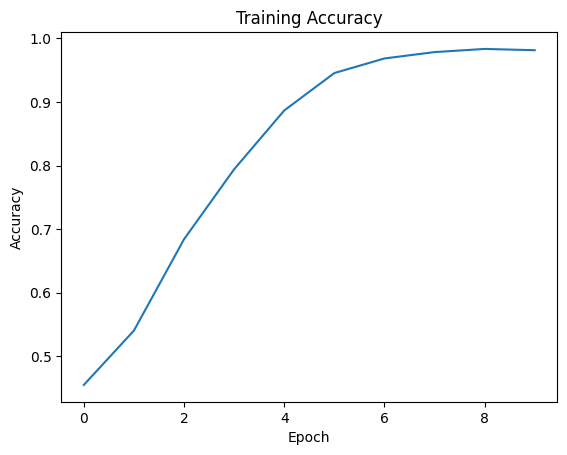

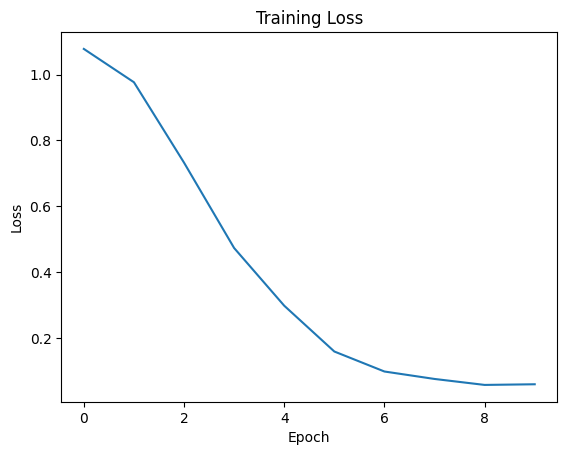

Accuracy:  37.74999976158142


In [ ]:



embedding_vector_length = 64
model = Sequential()
model.add(Embedding(40000, embedding_vector_length, input_length=500))
model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_training, y_training, epochs=10, batch_size=32)

plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

scores = model.evaluate(X_testing, y_testing, verbose=0)
print("Accuracy: ", (scores[1] * 100))


In [ ]:
import pickle
filename = base_path+'lstm_binary_min_sim_(Enron+Yelp).sav'
pickle.dump(model,open(filename,'wb'))



# LSTM model split into training and testing sets (4600/400) for Yelp and Enron data, configured as a binary classifier incorporating a minimum similarity function.

In [25]:
# Creating binary labels for the training data
train_coh_bin = []
for i in range(4400):
    if train.dataset['labelA'].tolist()[i] >= 2:
        train_coh_bin.append(1)
    else:
        train_coh_bin.append(0)

train.dataset['coh_bin'] = train_coh_bin

# Creating binary labels for the test data
test_coh_bin = []
for i in range(400):
    if test.dataset['labelA'].tolist()[i] >= 2:
        test_coh_bin.append(1)
    else:
        test_coh_bin.append(0)

test.dataset['coh_bin'] = test_coh_bin


In [29]:
# Convert binary labels to numpy array
train_bin_coh_array = np.array(train.dataset['coh_bin'])

# Convert binary labels to one-hot encoded format for training data
train_encoded = to_categorical(train_bin_coh_array)

# Convert binary labels to numpy array
test_bin_coh_array = np.array(test.dataset['coh_bin'])

# Convert binary labels to one-hot encoded format for test data
test_encoded = to_categorical(test_bin_coh_array)


In [30]:
np.random.seed(7)
X_train = sequence.pad_sequences(train.dataset['encoding'],maxlen = 500)
y_train = train_encoded
X_test = sequence.pad_sequences(test.dataset['encoding'],maxlen=500)
y_test = test_encoded




In [31]:

import numpy as np

# Convert pandas Series to numpy array
similarity_train = train.dataset['similarity_scores'].values

# Add a new axis to create a new column
similarity_train = similarity_train[:, np.newaxis]

# Append the new column to X_train
X_train = np.append(similarity_train, X_train, axis=1)

# Repeat the same process for X_testlstm_binary_min_sim_yahoo
similarity_test = test.dataset['similarity_scores'].values
similarity_test = similarity_test[:, np.newaxis]
X_test = np.append(similarity_test, X_test, axis=1)


Epoch 1/15
138/138 [==============================] - 22s 126ms/step - loss: 0.6256 - accuracy: 0.6764
Epoch 2/15
138/138 [==============================] - 13s 95ms/step - loss: 0.4537 - accuracy: 0.7923
Epoch 3/15
138/138 [==============================] - 11s 82ms/step - loss: 0.2115 - accuracy: 0.9180
Epoch 4/15
138/138 [==============================] - 8s 58ms/step - loss: 0.0752 - accuracy: 0.9766
Epoch 5/15
138/138 [==============================] - 9s 64ms/step - loss: 0.0315 - accuracy: 0.9927
Epoch 6/15
138/138 [==============================] - 9s 65ms/step - loss: 0.0217 - accuracy: 0.9957
Epoch 7/15
138/138 [==============================] - 7s 54ms/step - loss: 0.0213 - accuracy: 0.9948
Epoch 8/15
138/138 [==============================] - 6s 44ms/step - loss: 0.0173 - accuracy: 0.9959
Epoch 9/15
138/138 [==============================] - 7s 54ms/step - loss: 0.0185 - accuracy: 0.9943
Epoch 10/15
138/138 [==============================] - 5s 38ms/step - loss: 0.0175 - ac

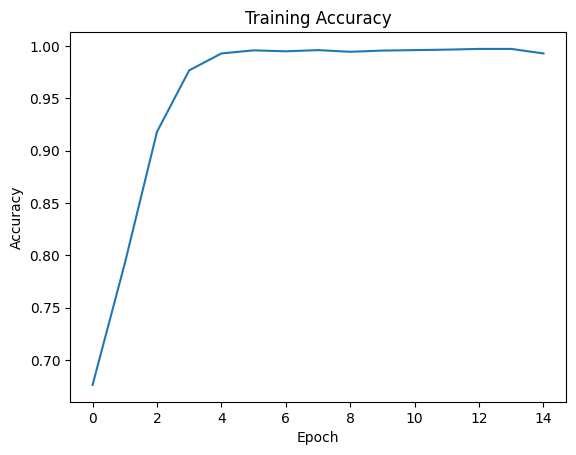

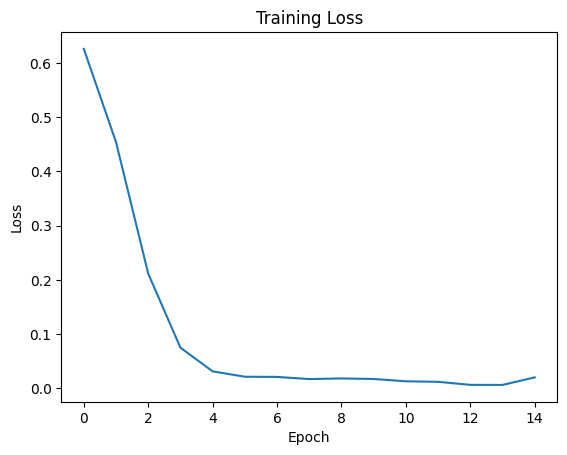

Accuracy:  57.499998807907104


In [32]:

import matplotlib.pyplot as plt


embedding_vector_length = 64
model = Sequential()
model.add(Embedding(40000, embedding_vector_length, input_length=501))
model.add(LSTM(64, dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the  model and store the history
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Evaluate the model on test data
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ", (scores[1] * 100))
